In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("Projections and signal restoration.ipynb")

# Matrix Analysis 2024 - EE312

## Week 3 - Signal restoration using projections
[LTS2](https://lts2.epfl.ch)

Let us consider a signal with $N$ elements, i.e. a vector in $\mathbb{R}^N$. 
Under our observations conditions, we can only recover partially the signal's values, the other remain unknown, i.e. we know that:

$x[k] = x_k$ for $k\in E = \{e_0, e_1, \dots,e_{M-1}\}$, with $E\in\mathbb{N}^M$ and $e_i\neq e_j \forall i\neq j$ (i.e. each known index is unique).

We also make the assumption that the signal is contained within **lower frequencies of the spectrum**. This can be expressed using the (normalized) Fourier matrix you have constructed last week $\hat{W}$.

In this notebook, we will try to reconstruct the signal by projecting its observation successively on the Fourier subspace defined above, then back to its original domain (with the constraint regarding its values), then on the Fourier domain, etc. This is a simplified version of a more general method called ["Projection onto convex sets" (POCS)](https://en.wikipedia.org/wiki/Projections_onto_convex_sets). The method is illustrated by the figure below (of course you do not project on lines but on spaces having larger dimension).

![POCS](images/pocs.png "POCS")

### 1. Low-pass filter
Let us first create example signals to validate our implementation of the filtering operation.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
N = 100
k = np.arange(0, N)
w1 = 3
w2 = 7
w3 = 12

# generate simple signals
x1 = np.cos(2*w1*np.pi*k/N) + np.sin(2*w2*np.pi*k/N)
x2 = np.sin(2*w1*np.pi*k/N) + np.cos(2*w3*np.pi*k/N)

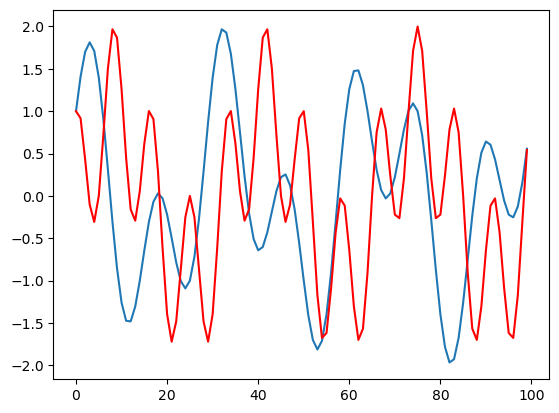

In [3]:
# visualize the base signals
plt.plot(x1)
plt.plot(x2, 'r')

1. Implement a function that returns the normalized Fourier matrix of size N (use your implementation from week 2)

In [4]:
def fourier_matrix(N):
    if N <=0:
        raise ValueError('N must be a positive integer')
    
    res = np.zeros((N,N),dtype=complex)

    for j in range(N):
        for k in range(N):
            res[j,k] = np.exp(-2j*np.pi*j*k/N)/np.sqrt(N)

    return res

In [5]:
grader.check("q1")

q1 results: All test cases passed!
q1 - 1 message: Good, your implementation returns correct results
q1 - 2 message: Good, your implementation returns an orthogonal matrix

In [6]:
W_hat = fourier_matrix(N)

Let $X = \hat{W}x$, $X$ is the *discrete Fourier transform* of the input signal $x$. The frequency condition can then be rewritten as 

$X[k] = 0$ for $w_c < k\leq N-w_c$. 

2. Implement the function that returns a $N\times N$ matrix $P$, s.t. $PX$ satisfies the above condition for a given $w_c$. Make sure the input values are valid, if not raise a `ValueError` exception.

In [7]:
def lowpass_matrix(N, w_c):
    """
    Computes the P matrix that will remove high-frequency coefficients in a DFT transformed signal

    Parameters
    ----------
    N : length of the input signal
    w_c : cutoff frequency

    Returns
    -------
    The P matrix
    """
    if N <=0:
        raise ValueError('N must be a positive integer')
    if w_c < 0 or w_c > N/2:
        raise ValueError('w_c must be between 0 and N/2')

    res = np.eye(N, dtype=complex)
    for i in range(N):
        if i >= w_c and i <= N-w_c:
            res[i,i] = 0
    

    return res

In [8]:
grader.check("q2")

q2 results: All test cases passed!
q2 - 1 message: Good, your implementation returns correct results
q2 - 2 message: Good, you properly validated parameters before computing the result

3. Now let us try the filtering on the test signals and make sure it behaves appropriately. Using the matrix $P$ defined above, choose the parameter $w_c$ approiately s.t. the filtered signals retain $w_1$ and $w_2$ but discard $w_3$.

In [9]:
w_c = 10

In [10]:
# Compute the DFT of x1 and x2
X1 = W_hat@x1
X2 = W_hat@x2

# Get the lowpass filter matrix
P = lowpass_matrix(N, w_c)

# Filter X1 and X2 and apply inverse DFT
x1_f = np.real(W_hat.T@P@X1)
x2_f = np.real(W_hat.T@P@X2)

NB: Make sure the filtered output is **real** (or its imaginary part should be smaller than $10^{-12}$).

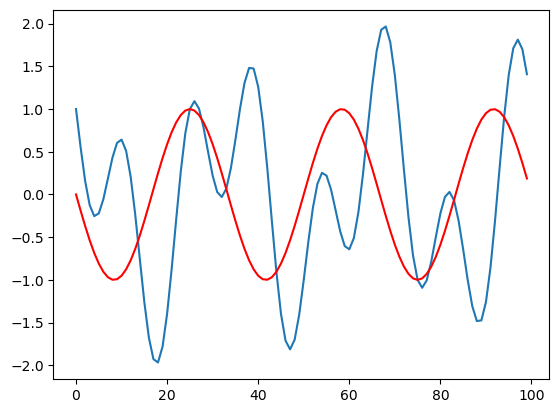

In [11]:
# Plot the filtered signals
# x1_f should still contain both frequencies, x2_f only one
plt.plot(x1_f)
plt.plot(x2_f, 'r')

In [12]:
grader.check("q3")

q3 results: All test cases passed!
q3 - 1 message: Your value of w_c looks correct

<!-- BEGIN QUESTION -->

4. Prove that $P$ is a projection.


We can easily see that P is idempotent:<br>

P is basically an identity matrix with some zeros on the diagonal so $P \cdot P = P$

<!-- END QUESTION -->

### 2. Signal extension

In order to express the condition on $x[k]$ as a pure matrix operation we need to make use of an extension of the input signal and design a slightly different Fourier transform matrix to use properly those extended signals. 

Let us denote by $x_E$ the vector from $\mathbb{R}^M$ containing the known values of $x$, i.e. the $x_k$ for $k\in E$.

For each vector $y$ in $\mathbb{R}^N$ we define its extension as $\tilde{y} = \begin{pmatrix}y \\ x_E\end{pmatrix}$. 

**This notation will remain throughout the notebook**, i.e. a vector with a tilde denotes its extension made by adding the $x_E$ values at the end.

5. Let us define the matrix $B_E$ and $y=B_E x$, s.t. $y[k] = 0$ if $k\in E$ and $y[k] = x[k]$ otherwise. Write a function that returns its extended version $\tilde{B_E}$ s.t. $\tilde{y}=\tilde{B_E}\tilde{x}$, for any $x\in\mathbb{R}^N$. 

- $\tilde{B_E}$ is a square matrix of size $N+M$.
- Check the validity of parameters and raise a `ValueError`  in case of invalid inputs.

In [49]:
def Bt_E(N, E):
    """
    Computes the $\tilde{B}_E$ matrix 

    Parameters
    ----------
    N : length of the input signal
    E : list of suitable indices. e.g. for N=5 a valid E could be [1, 3]

    Returns
    -------
    The $\tilde{B}_E$ matrix 
    """
    if N <=0:
        raise ValueError('N must be a positive integer')
    if len(E) == 0:
        raise ValueError('E must contain at least one element')
    if min(E) < 0 or max(E) >= N:
        raise ValueError('E must contain only valid indices')
    E=set(E)
    res=np.eye(N+len(E), dtype=complex)
    for i in E:
        res[i,i] = 0

    return res

In [50]:
grader.check("q5")

q5 results: All test cases passed!
q5 - 1 message: Good, your implementation returns correct results
q5 - 2 message: Good, your implementation returns correct results
q5 - 3 message: Good, you properly validated parameters before computing the result

Let us now design $C_E$ as an operator from $\mathbb{R}^{N+M} \rightarrow \mathbb{R}^{N+M}$ such that when applied to any extended vector $\tilde{z}$ s.t. $\tilde{z}[k] = 0, \forall k\in E$ as input (i.e. for instance the output of $\tilde{B}_E$), it generates a vector $\tilde{z}_R$ s.t.:

$\tilde{z}_R[k] = \begin{matrix} x_k \text{ if } k\in E \\ \tilde{z}[k] \text{ otherwise} \end{matrix}$

1. Write a function that generates $C_E$. 

In [94]:
def C_E(N, E):
    """
    Computes the $C_E$ matrix 

    Parameters
    ----------
    N : length of the input signal
    E : list of suitable indices. e.g. for N=5 a valid E could be [1, 3]

    Returns
    -------
    The $C_E$ matrix 
    """
    E=set(E)
    
    if N <=0:
        raise ValueError('N must be a positive integer')
    if len(E) == 0:
        raise ValueError('E must contain at least one element')
    if min(E) < 0 or max(E) >= N:
        raise ValueError('E must contain only valid indices')

    res=np.eye(N+np.max(E), dtype=complex)
    for i in range(N):
        if i in E:
            res[i, i+N] = 1
        #res[i, i-1+N] = 1
        #res[i, i] = 1
        

    return res

print(C_E(5, [1, 3]))

TypeError: unsupported operand type(s) for +: 'int' and 'set'

In [89]:
grader.check("q6")

q6 results:
    q6 - 1 message: Check your implementation

    q6 - 1 result:
        ❌ Test case failed
        Trying:
            N = 5
        Expecting nothing
        ok
        Trying:
            E = [1, 3]
        Expecting nothing
        ok
        Trying:
            E2 = [1, 1, 3, 3]
        Expecting nothing
        ok
        Trying:
            C = np.array([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
        Expecting nothing
        ok
        Trying:
            np.testing.assert_array_almost_equal(C_E(N, E), C)
        Expecting nothing
        **********************************************************************
        Line 5, in q6 0
        Failed example:
            np.testing.assert_array_almost_equal(C_E(N, E), C)
        Exception raised:
            Traceback (most recent call last):
              File "/home/mikey/miniconda3/envs/matrix-analysis-2024/lib/python3.10/doctest.py", line 1350, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q6 0[4]>", line 1, in <module>
                np.testing.assert_array_almost_equal(C_E(N, E), C)
              File "/home/mikey/.local/lib/python3.10/site-packages/numpy/testing/_private/utils.py", line 1046, in assert_array_almost_equal
                assert_array_compare(compare, x, y, err_msg=err_msg, verbose=verbose,
              File "/home/mikey/.local/lib/python3.10/site-packages/numpy/testing/_private/utils.py", line 844, in assert_array_compare
                raise AssertionError(msg)
            AssertionError: 
            Arrays are not almost equal to 6 decimals

            Mismatched elements: 2 / 49 (4.08%)
            Max absolute difference: 1.
            Max relative difference: 1.
             x: array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
                   [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
                   [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],...
             y: array([[1., 0., 0., 0., 0., 0., 0.],
                   [0., 1., 0., 0., 0., 1., 0.],
                   [0., 0., 1., 0., 0., 0., 0.],...
        Trying:
            np.testing.assert_array_almost_equal(C_E(N, E2), C)
        Expecting nothing
        **********************************************************************
        Line 6, in q6 0
        Failed example:
            np.testing.assert_array_almost_equal(C_E(N, E2), C)
        Exception raised:
            Traceback (most recent call last):
              File "/home/mikey/miniconda3/envs/matrix-analysis-2024/lib/python3.10/doctest.py", line 1350, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q6 0[5]>", line 1, in <module>
                np.testing.assert_array_almost_equal(C_E(N, E2), C)
              File "/home/mikey/.local/lib/python3.10/site-packages/numpy/testing/_private/utils.py", line 1046, in assert_array_almost_equal
                assert_array_compare(compare, x, y, err_msg=err_msg, verbose=verbose,
              File "/home/mikey/.local/lib/python3.10/site-packages/numpy/testing/_private/utils.py", line 844, in assert_array_compare
                raise AssertionError(msg)
            AssertionError: 
            Arrays are not almost equal to 6 decimals

            Mismatched elements: 2 / 49 (4.08%)
            Max absolute difference: 1.
            Max relative difference: 1.
             x: array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
                   [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
                   [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],...
             y: array([[1., 0., 0., 0., 0., 0., 0.],
                   [0., 1., 0., 0., 0., 1., 0.],
 

<!-- BEGIN QUESTION -->

7. What is the effect of $D_E = C_E \tilde{B}_E$ on an extended signal $\tilde{x}$ ? 

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

8. Verify (numerically on an example) that $D_E$ is a projector. You can use the function `numpy.testing.assert_array_almost_equal` to check that arrays are almost equal (with a good precision)

In [17]:
# Set some parameters
N=5
E=[1,3]
# Compute D_E
D_E = ...
# Now check that D_E is a projector
...

Ellipsis

<!-- END QUESTION -->

### 3. Extended signals in the Fourier domain
Let us now define an operator that will work almost as the normalized Fourier transform, except that it will be applied to the extended signals and preserve the $x_E$ part. This can be easily done using the following block matrix:

$\tilde{W} = \begin{pmatrix}\hat{W} & 0 \\0 & I_M\end{pmatrix}$.


Using this definition, multiplying an extended signal $\tilde{x}$ by $\tilde{W}$ will result in a vector containing the Fourier transform of $x$ followed by $x_E$, preserving the known initial values.

<!-- BEGIN QUESTION -->

9. Prove that $\tilde{W}$ is orthonormal. 

_Type your answer here, replacing this text._

<!-- END QUESTION -->

10. Write a function that returns $\tilde{W}$.

In [18]:
def Wt_E(N, E):
    """
    Computes the $\tilde{W}_E$ matrix 

    Parameters
    ----------
    N : length of the input signal
    E : list of suitable indices. e.g. for N=5 a valid E could be [1, 3]

    Returns
    -------
    The $\tilde{W}_E$ matrix 
    """
    ...

In [19]:
grader.check("q10")

q10 results:
    q10 - 1 message: Check your implementation

    q10 - 1 result:
        ❌ Test case failed
        Trying:
            from scipy.linalg import dft
        Expecting nothing
        ok
        Trying:
            w = Wt_E(12, [1, 2, 4])
        Expecting nothing
        ok
        Trying:
            assert w.shape == (15, 15)
        Expecting nothing
        **********************************************************************
        Line 3, in q10 0
        Failed example:
            assert w.shape == (15, 15)
        Exception raised:
            Traceback (most recent call last):
              File "/home/mikey/miniconda3/envs/matrix-analysis-2024/lib/python3.10/doctest.py", line 1350, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q10 0[2]>", line 1, in <module>
                assert w.shape == (15, 15)
            AttributeError: 'NoneType' object has no attribute 'shape'
        Trying:
            np.testing.assert_array_almost_equal(w[:12, :12], dft(12, scale='sqrtn'))
        Expecting nothing
        **********************************************************************
        Line 4, in q10 0
        Failed example:
            np.testing.assert_array_almost_equal(w[:12, :12], dft(12, scale='sqrtn'))
        Exception raised:
            Traceback (most recent call last):
              File "/home/mikey/miniconda3/envs/matrix-analysis-2024/lib/python3.10/doctest.py", line 1350, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q10 0[3]>", line 1, in <module>
                np.testing.assert_array_almost_equal(w[:12, :12], dft(12, scale='sqrtn'))
            TypeError: 'NoneType' object is not subscriptable
        Trying:
            np.testing.assert_array_almost_equal(w[12:, 12:], np.eye(3))
        Expecting nothing
        **********************************************************************
        Line 5, in q10 0
        Failed example:
            np.testing.assert_array_almost_equal(w[12:, 12:], np.eye(3))
        Exception raised:
            Traceback (most recent call last):
              File "/home/mikey/miniconda3/envs/matrix-analysis-2024/lib/python3.10/doctest.py", line 1350, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q10 0[4]>", line 1, in <module>
                np.testing.assert_array_almost_equal(w[12:, 12:], np.eye(3))
            TypeError: 'NoneType' object is not subscriptable

    q10 - 2 message: Did you forget to validate the input parameters before performing the computation ?

    q10 - 2 result:
        ❌ Test case failed
        Trying:
            with np.testing.assert_raises(ValueError):
                Wt_E(10, [12, 5])
        Expecting nothing
        **********************************************************************
        Line 1, in q10 1
        Failed example:
            with np.testing.assert_raises(ValueError):
                Wt_E(10, [12, 5])
        Exception raised:
            Traceback (most recent call last):
              File "/home/mikey/miniconda3/envs/matrix-analysis-2024/lib/python3.10/doctest.py", line 1350, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q10 1[0]>", line 1, in <module>
                with np.testing.assert_raises(ValueError):
              File "/home/mikey/miniconda3/envs/matrix-analysis-2024/lib/python3.10/unittest/case.py", line 226, in __exit__
                self._raiseFailure("{} not raised".format(exc_name))
              File "/home/mikey/miniconda3/envs/matrix-analysis-2024/lib/python3.10/unittest/case.py", line 163, in _raiseFailure
                raise self.test_case.failureException(msg)
            AssertionError: ValueError not raised
        Trying:
            with np.testing.assert_raises(ValueError):
                Wt_E(8, [2, -1])
        Expecting nothing
        **

11. Recalling the low-pass matrix $P$ defined previously, build $\tilde{P}$ s.t. when applied to $\tilde{W}\tilde{x}$ it results in a vector containing the filtered values (still in the Fourier domain) followed by $x_E$.

In [20]:
def Pt_E(N, M, w_c):
    ...

<!-- BEGIN QUESTION -->

12. A signal $\tilde{x}$ will be filtered by doing $\tilde{W}^H \tilde{P}\tilde{W}\tilde{x}$.
Prove that this is a projection.

_Type your answer here, replacing this text._

<!-- END QUESTION -->

### 4. Signal restoration

<!-- BEGIN QUESTION -->

13. We can now use all defined above to implement a function that performs an iteration, taking as input the extension of $x$ as defined above, that does the following:
- compute the filtered version of the signal using $\tilde{W}^H \tilde{P}\tilde{W}$ (i.e. projecting on the space of "smooth signals")
- restore the known values in the signal by using $D_E = C_E\tilde{B}_E$ (i.e project back on the space of signals having the known initial values we have set)

Make sure to force the result to real values by using `np.real` before returning

In [21]:
def restoration_iter(Wt, Pt, Dt, xt):
    """
    Performs a full restoration iteration by
    - projecting the signal into Fourier, performing low-pass filtering followed by inverse DFT
    - restoring the known initial values into the filtered signal

    Parameters
    ----------
    Wt : \tilde{W} matrix
    Pt : \tilde{P} matrix
    Dt : \tilde{D} matrix
    xt : \tilde{x} vector

    Returns
    -------
    The new $\tilde{x} vector after the iteration
    """
    ...

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

15. Finally we are ready to apply all this to an example.

In [22]:
# Setup an example
N = 100
w_c = 10 # cut-off
w1 = 3
w2 = 7
E =  np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95])
# E =  np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90]) # try with less known points
M = len(E)
x = np.cos(2*w1*np.pi*np.arange(0, N)/N) + np.sin(2*w2*np.pi*np.arange(0,N)/N) # original signal

# Create a signal that is only noise, except at known initial values
y = np.random.rand(N) # 
y[E] = x[E] # restore known values
xe = x[E]

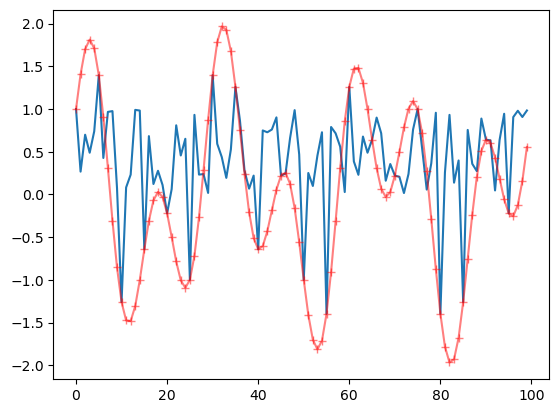

In [23]:
plt.plot(y) # plot the "acquired" signal
plt.plot(x, 'r+-', alpha=0.5) # plot the ground truth signal

Generate $\tilde{y}$ (this only need to be done once)

In [24]:
yt = np.append(y, xe) # SOLUTION

Run a number of iterations of the method and plot the result:

In [25]:
def signal_restore(Wt, Pt, Dt, yt, niter=20):
    yr0 = yt # initialize
    for k in range(niter):
        yr1 = restoration_iter(Wt, Pt, Dt, yr0)
        yr0 = yr1
    return yr1

In [26]:
Wt = Wt_E(N, E)
Dt = C_E(N, E)@Bt_E(N, E)
Pt = Pt_E(N, M, w_c)
yr = signal_restore(Wt, Pt, Dt, yt)

ValueError: matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

In [ ]:
plt.plot(yr[:N]) # plot reconstructed signal
plt.plot(x, 'r+', alpha=0.7) # plot original for comparison

Depending on $M$, you will find that the method can reconstruct perfectly the signal or not.  

<!-- END QUESTION -->



## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=True)